In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import pandas as pd

from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve,\
roc_auc_score

from contrastive.backbones.densenet import *
from contrastive.data.utils import read_labels

In [2]:
# get ACCpatterns dataset
numpy_all = "/neurospin/dico/data/deep_folding/current/datasets/ACCpatterns/crops/2mm/CINGULATE/mask/Rskeleton.npy"

X = np.load(numpy_all)
X.shape

(341, 17, 40, 38, 1)

25840


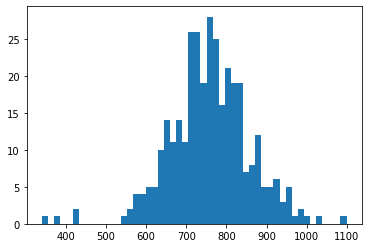

In [3]:
non_zeros = []

for x in X:
    non_zeros.append(np.count_nonzero(x))

print(np.size(X[0]))
plt.hist(non_zeros, bins=50)
plt.show()

## Try dimension reduction before training (PCA)

In [4]:
X_flatten = X.reshape(X.shape[0], np.prod(X.shape[1:]))
X_flatten.shape

(341, 25840)

In [15]:
n_pca = 100

pca = PCA(n_components=n_pca)
X_reduced = pca.fit_transform(X_flatten)
print(X_reduced.shape)

X_reduced = torch.from_numpy(X_reduced).type(torch.float)
X_reduced

(341, 100)


tensor([[ 245.7662,  237.2004,   62.2442,  ..., -133.4796,  -57.0979,
          -26.8270],
        [ 197.3744,  -69.5136,  244.6385,  ...,   14.8301,  -82.0342,
          -62.4103],
        [ 280.1981,   17.5589,  185.6597,  ...,  -89.9254,  -59.9093,
           29.6441],
        ...,
        [   4.1137,   85.1607, -140.7252,  ...,  -30.3269,   41.5756,
           -0.7341],
        [ -84.7407,   -8.6205,  -22.7353,  ...,   87.7418,  -10.9102,
           -3.1039],
        [-165.8072,  -89.3121,  117.3370,  ...,  -21.4307,   70.8993,
           56.3121]])

In [16]:
# get the labels (0 = no paracingulate, 1 = paracingulate)
# /!\ use read_labels
labels = read_labels("/neurospin/dico/data/bv_databases/human/partially_labeled/ACCpatterns/all.csv",
                'long_name', ["Right_PCS"])

Y = labels.Right_PCS.values

Y = torch.from_numpy(Y).type(torch.float)
Y

INFO:utils.py: Labels to keep = ['Right_PCS'] of type <class 'list'>
INFO:utils.py: Column Right_PCS sorted as categories. Categories are Index(['absent', 'present'], dtype='object')
INFO:utils.py: Head of subject_labels:
            Subject  Right_PCS
0  nih_chp_04701_t1          0
1  nih_chp_01534_t1          1
2  nih_chp_04623_t1          1
3  nih_chp_01503_t1          0
4  nih_chp_00404_t1          1
INFO:utils.py: Number of non-NaN subjects with label = 341


tensor([0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0.,
        0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1.,
        1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1.,
        1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1.,
        0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1.,
        0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
        1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0.,
        1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1.,
        1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 1., 1., 0., 

In [17]:
class BinaryClassifier(pl.LightningModule):
    def __init__(self, layers_sizes, activation=None, loss='MSE', keep_log=False):
        super().__init__()
        self.keep_log = keep_log
        self.layers = nn.Sequential()
        for i in range(len(layers_sizes)-1):
            self.layers.add_module('layer%d'%(i), nn.Linear(layers_sizes[i], layers_sizes[i+1]))

        if activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        else:
            self.activation = None
        
        if loss == 'BCE':
            self.loss = nn.BCELoss()
        else:
            self.loss = nn.MSELoss()
        

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        for layer in self.layers:
            x = layer(x)
        if self.activation:
            x = self.activation(x)
        return x
    
    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        x, y = batch
        x = x.view(x.size(0), -1)
        output = self.forward(x)
        y = y.view(y.size(0), 1)
        loss = self.loss(output, y)
        if self.keep_log:
            print("KEEP LOG")
            # Logging to TensorBoard by default
            self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [18]:
classifier = BinaryClassifier([n_pca, 10, 1], activation=None, loss='MSE')

In [19]:
train_set = TensorDataset(X_reduced, Y)
train_loader_lin = DataLoader(train_set, batch_size=10)

trainer_lin = pl.Trainer(max_epochs=10)
trainer_lin.fit(model=classifier, train_dataloaders=train_loader_lin)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 1.0 K 
1 | loss   | MSELoss    | 0     
--------------------------------------
1.0 K     Trainable params
0         Non-trainable params
1.0 K     Total params
0.004     Total estimated model params size (MB)
/neurospin/dico/agaudin/Runs/03_monkeys/2022_jchavas_cingulate_inhibitory_control/venv_local/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/neurospin/dico/agaudin/Runs/03_monkeys/2022_jchavas_cingulate_inhi

Training: 0it [00:00, ?it/s]

In [20]:
# get predictions
Y_pred = classifier.forward(X_reduced)
Y_pred = Y_pred.detach().numpy()
Y = Y.detach_().numpy()

0.6187683284457478


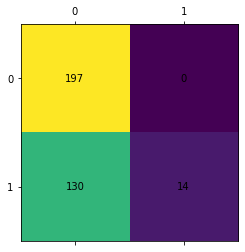

In [21]:
# confusion matrix
binary_preds = (Y_pred >= 0.5)

print(accuracy_score(Y, binary_preds))
conf_mat = confusion_matrix(Y, binary_preds)

fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
ax.matshow(conf_mat)

for (i, j), z in np.ndenumerate(conf_mat):
    ax.text(j, i, '{:1.0f}'.format(z), ha='center', va='center')

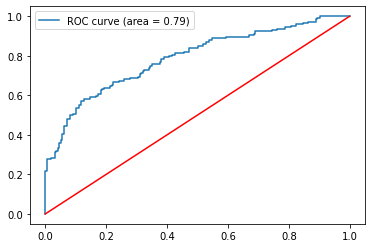

In [22]:
# roc curve
curves = roc_curve(Y, Y_pred)
roc_auc = roc_auc_score(Y, Y_pred)

plt.plot(curves[0], curves[1], label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0,1],[0,1],color='r')
plt.legend()

In [23]:
data = {"true": Y,
        "pred": Y_pred.flatten()}

df = pd.DataFrame(data)
df

,true,pred
0,0.0,-0.076956
1,1.0,0.395233
2,1.0,0.137753
3,0.0,-0.151873
4,1.0,0.108997
...,...,...
336,1.0,0.237254
337,0.0,-0.033554
338,1.0,0.039403
339,1.0,-0.115169


144 - 197
-0.6475701 1


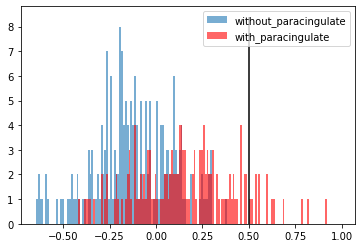

In [24]:
with_paracingulate = df[df.true == 1]
without_paracingulate = df[df.true == 0]

print(with_paracingulate.shape[0], "-", without_paracingulate.shape[0])

x_min = min(0, np.min(df.pred))
x_max = max(1, np.max(df.pred))

print(x_min, x_max)

plt.hist(without_paracingulate.pred, bins=np.arange(x_min,x_max,0.01), alpha=0.6)
plt.hist(with_paracingulate.pred, bins=np.arange(x_min,x_max,0.01), alpha=0.6, color='r')
plt.legend(['without_paracingulate', "with_paracingulate"])

ax = plt.gca()
plt.vlines([0.5], ax.get_ylim()[0], ax.get_ylim()[1], color='black')
plt.show()

## Ensemble methods

See https://scikit-learn.org/stable/modules/ensemble.html

In [80]:
from sklearn.ensemble import *
from sklearn.model_selection import train_test_split

### Import data

In [57]:
# get ACCpatterns dataset
embeddings_path = "/neurospin/dico/agaudin/Runs/03_monkeys/Output/analysis_folders/main_models/humans/HCP_4_4/SimCLR_embeddings/full_embeddings.csv"

X = pd.read_csv(embeddings_path, index_col=0)
X = X.sort_index()
labels = read_labels("/neurospin/dico/data/bv_databases/human/partially_labeled/ACCpatterns/all.csv",
                'long_name', ["Right_PCS"])
labels = labels.sort_values(by='Subject')

X = X.values
Y = labels.Right_PCS.values

INFO:utils.py: Labels to keep = ['Right_PCS'] of type <class 'list'>
INFO:utils.py: Column Right_PCS sorted as categories. Categories are Index(['absent', 'present'], dtype='object')
INFO:utils.py: Head of subject_labels:
            Subject  Right_PCS
0  nih_chp_04701_t1          0
1  nih_chp_01534_t1          1
2  nih_chp_04623_t1          1
3  nih_chp_01503_t1          0
4  nih_chp_00404_t1          1
INFO:utils.py: Number of non-NaN subjects with label = 341


In [77]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y,test_size=0.5)

### Random forest

In [78]:
forest = RandomForestClassifier(n_estimators=100)
forest.fit(Xtrain,Ytrain)
Y_forest_train = forest.predict(Xtrain)
Y_forest_test = forest.predict(Xtest)

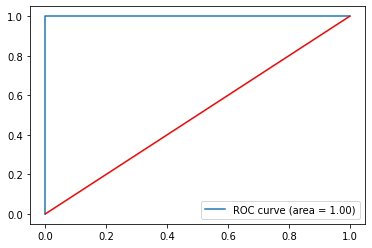

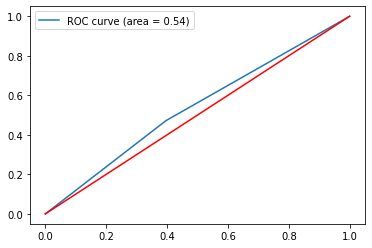

In [79]:
# roc curve
curves = roc_curve(Ytrain, Y_forest_train)
roc_auc = roc_auc_score(Ytrain, Y_forest_train)

plt.plot(curves[0], curves[1], label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0,1],[0,1],color='r')
plt.legend()

plt.figure()
curves = roc_curve(Ytest, Y_forest_test)
roc_auc = roc_auc_score(Ytest, Y_forest_test)

plt.plot(curves[0], curves[1], label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0,1],[0,1],color='r')
plt.legend()
# un léger overfitting donc...

### Bagging

BaggingClassifier(max_samples=0.5, n_estimators=100)


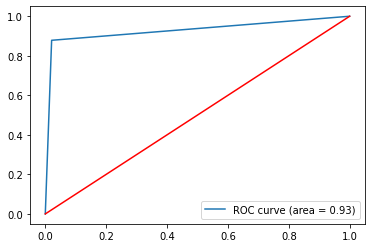

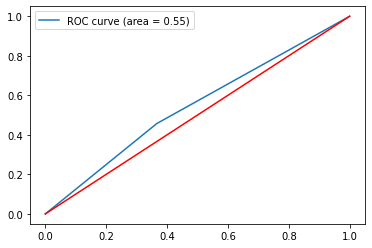

RandomForestClassifier()


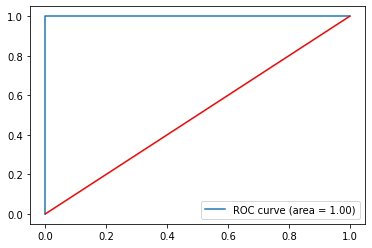

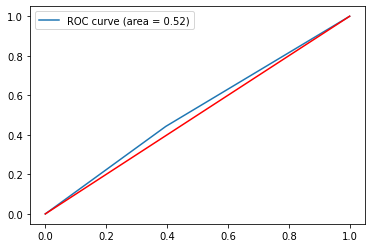

AdaBoostClassifier(n_estimators=100)


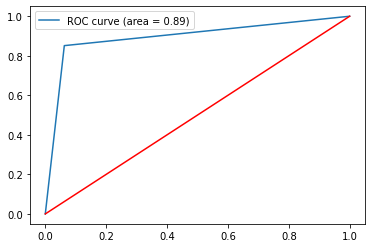

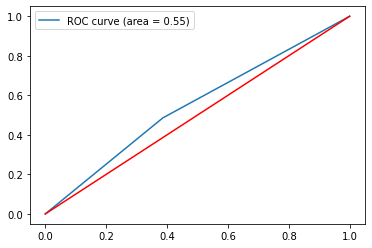

GradientBoostingClassifier(subsample=0.5)


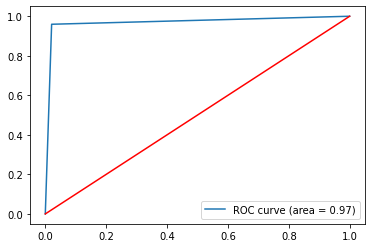

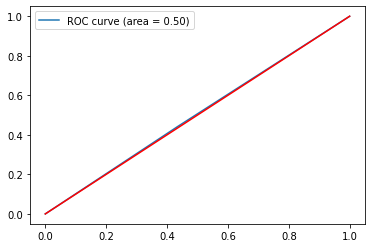

In [84]:
n_estimators = 100

baggins = BaggingClassifier(n_estimators=n_estimators, max_samples=0.5)
forest = forest = RandomForestClassifier(n_estimators=n_estimators)
ada = AdaBoostClassifier(n_estimators=n_estimators)
boostree = GradientBoostingClassifier(n_estimators=n_estimators, subsample=0.5)


ensemble_classifiers = [baggins, forest, ada, boostree]

for classifier in ensemble_classifiers:
    print(classifier)
    classifier.fit(Xtrain,Ytrain)
    Y_pred_train = classifier.predict(Xtrain)
    Y_pred_test = classifier.predict(Xtest)

    # roc curve
    plt.figure()
    curves = roc_curve(Ytrain, Y_pred_train)
    roc_auc = roc_auc_score(Ytrain, Y_pred_train)

    plt.plot(curves[0], curves[1], label="ROC curve (area = %0.2f)" % roc_auc)
    plt.plot([0,1],[0,1],color='r')
    plt.legend()

    plt.figure()
    curves = roc_curve(Ytest, Y_pred_test)
    roc_auc = roc_auc_score(Ytest, Y_pred_test)

    plt.plot(curves[0], curves[1], label="ROC curve (area = %0.2f)" % roc_auc)
    plt.plot([0,1],[0,1],color='r')
    plt.legend()
    plt.show()